# Medical Cost Analysis

This notebook examines the insurence data on kaggle : https://www.kaggle.com/datasets/mirichoi0218/insurance for Aygaz Bootcamp Submission

## Importing Libraries

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor 
from sklearn.feature_selection import GenericUnivariateSelect
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [91]:
insurance = pd.read_csv("/Users/eren/Desktop/submission_insurance_bootcamp/insurance.csv")
insurance_df = insurance.copy()
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## EDA of the Insurance data

In [92]:
insurance_df.shape

(1338, 7)

In [93]:
insurance_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [94]:
insurance_df.drop_duplicates(inplace=True)

In [95]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [96]:
insurance_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [97]:
insurance_df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

### Bmi Distributions

<function matplotlib.pyplot.show(close=None, block=None)>

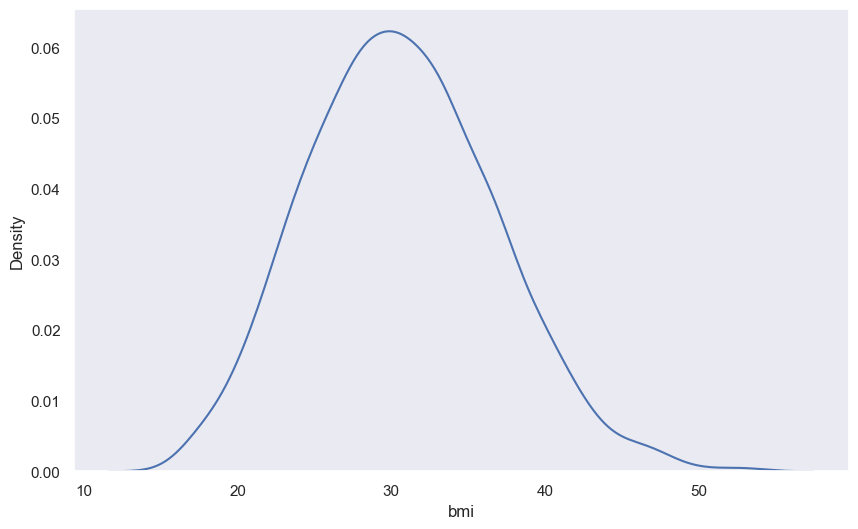

In [98]:
fig, axs = plt.subplots(1,1,figsize=(10,6))

sns.kdeplot(data=insurance_df,x="bmi") #i've explored the distribution diffrence between sex
plt.show

We can also visualize the difference between male and female distributions using hue parameter of the seaborn KDEPLOT

<function matplotlib.pyplot.show(close=None, block=None)>

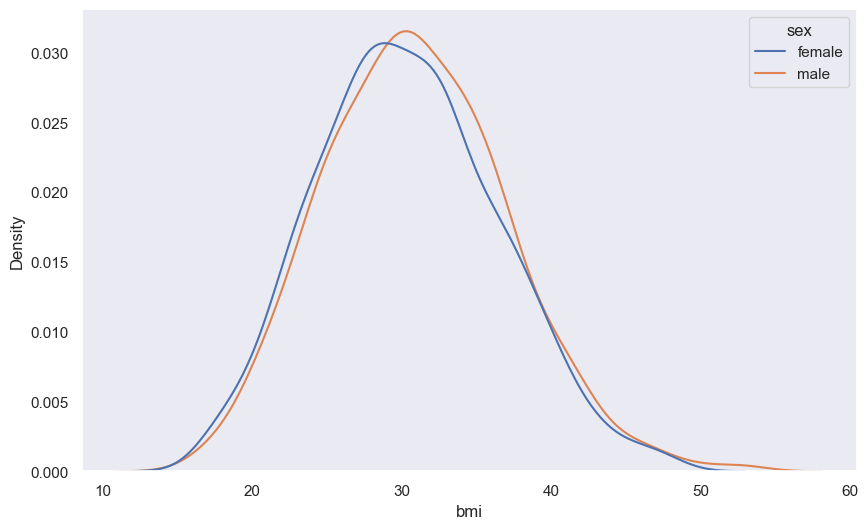

In [99]:
fig, axs = plt.subplots(1,1,figsize=(10,6))

sns.kdeplot(data=insurance_df,x="bmi",hue="sex") #i've explored the distribution diffrence between sex
plt.show

It seems that bmi data is normally distributed while males' having slightly more bmi than women.
We also can say roughly any data more than 50 in bmi is an outlier 

### Examining the relationship between smoker and charges

<Axes: xlabel='smoker', ylabel='charges'>

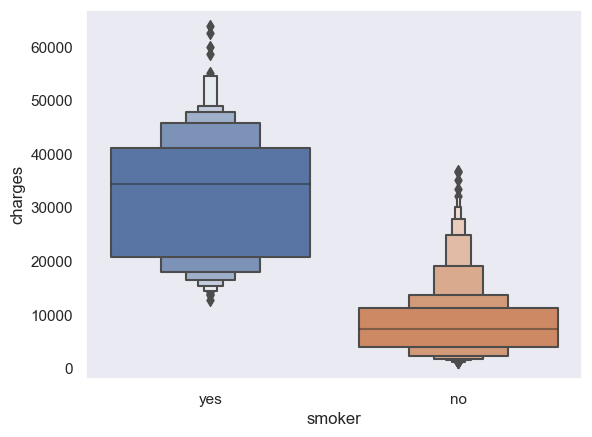

In [100]:
sns.boxenplot(data=insurance_df,x='smoker',y="charges")

There is a clear visualization that smoking affects medical costs more.

### Examining the relationship between smoker and region

<Axes: xlabel='region', ylabel='count'>

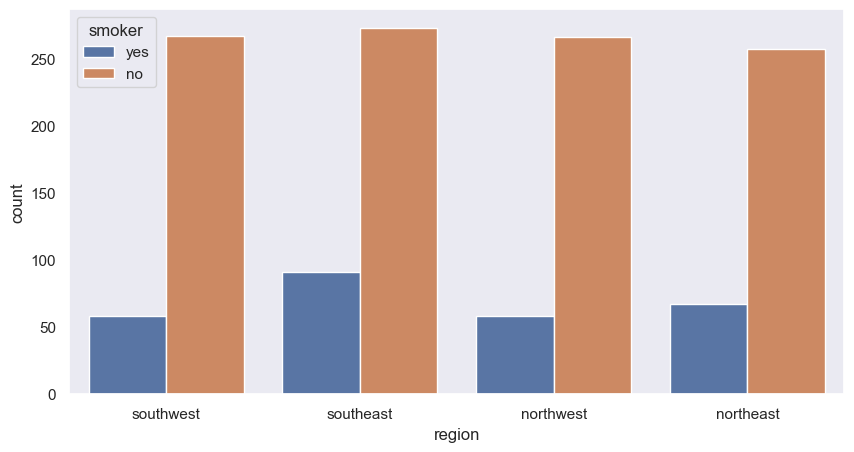

In [101]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(
    x="region",
    data=insurance_df,
    hue="smoker",
    ax=axs)

smokers by regions are approximately same while southeast having a slightly more smokers than the others.

### Examining the relationship between bmi and sex

<Axes: xlabel='sex', ylabel='bmi'>

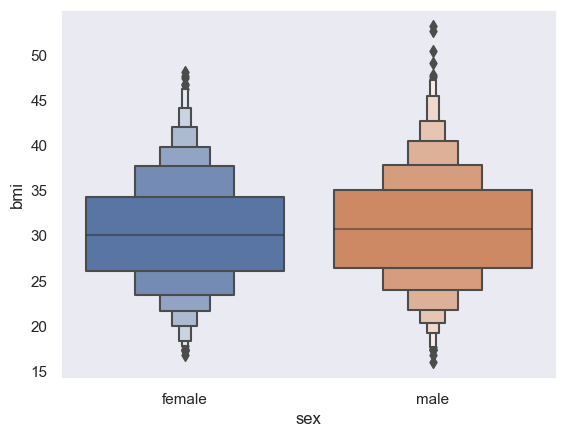

In [102]:
sns.boxenplot(data=insurance_df,x='sex',y="bmi") #this shows the distribution

there is a range diffrence between male and female bmi's male's are having more widened distribution. other than that just looking to this graph, we can say that 
sex and bmi is not related at all.

### Find the "region" with the most "children".

In [103]:
a =insurance_df.groupby("region")[["children"]].sum() #we clearly can see that southwest has the most children.
a

,children
region,
northeast,339
northwest,373
southeast,382
southwest,371


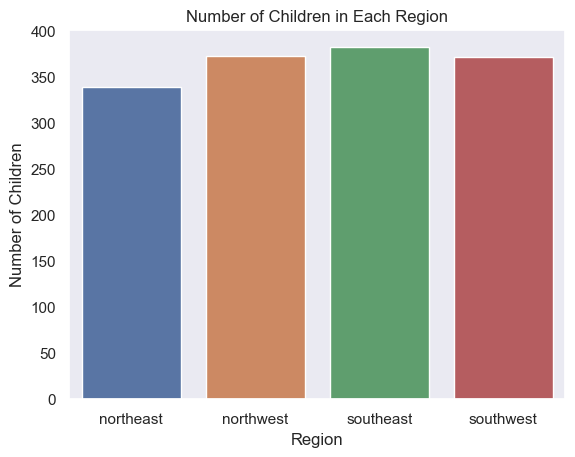

In [104]:
sns.barplot(data=a, x=a.index ,y="children")
plt.xlabel("Region")
plt.ylabel("Number of Children")
plt.title("Number of Children in Each Region")

plt.show()

Northeast has the least number of children 

### Examining the relationship between age and bmi

<Axes: xlabel='age', ylabel='bmi'>

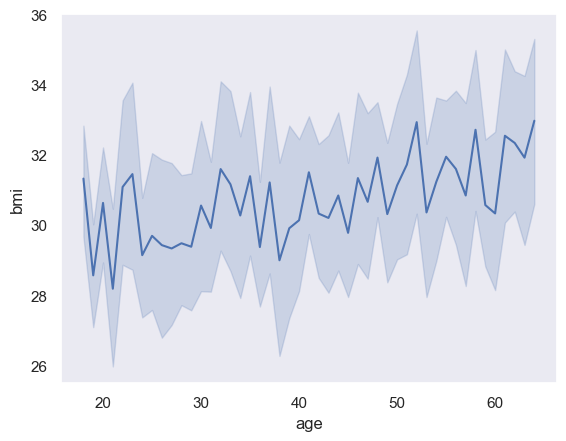

In [105]:
sns.lineplot(data=insurance_df,x="age",y="bmi")

Age and bmi values seems to have a weak correlation while being unstable (variance)

### Examining the relationship between children and bmi

<Axes: xlabel='children', ylabel='bmi'>

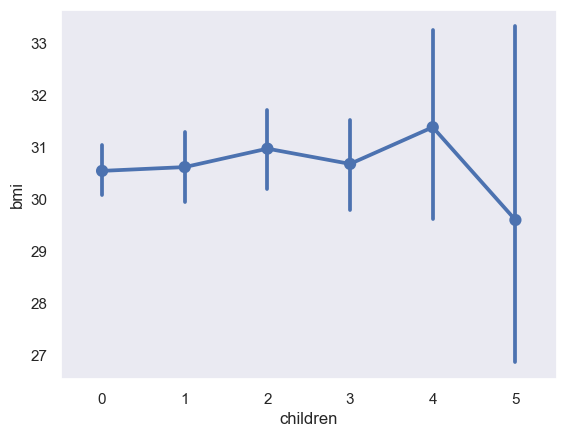

In [106]:
sns.pointplot(data=insurance_df,x="children",y="bmi")

There is a sudden change at chlidren of 5. this anomaly needs to be examined later on 

### Is there an outlier in the "bmi" variable? Please review.

<Axes: >

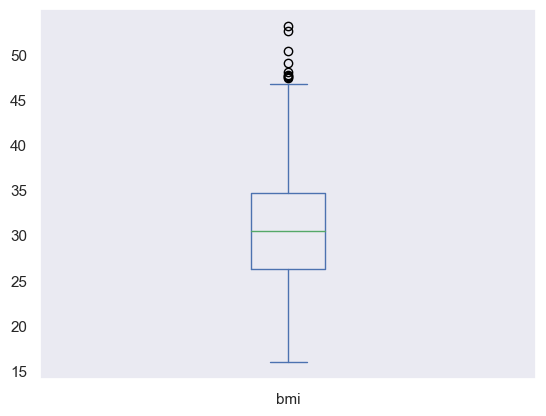

In [107]:
insurance_df["bmi"].plot(kind="box")

There are a few outliers in the bmi. Let's see which rows

In [108]:
Q1 = insurance_df['bmi'].quantile(0.25)
Q3 = insurance_df['bmi'].quantile(0.75)
IQR = Q3 - Q1   #calculation of interquartile range
insurance_df.loc[insurance_df['bmi'] >= Q3 + 1.5 *IQR]  #masking the upper limit 

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


### Examining the relationship between “bmi” and “charges”.

<Axes: xlabel='bmi', ylabel='charges'>

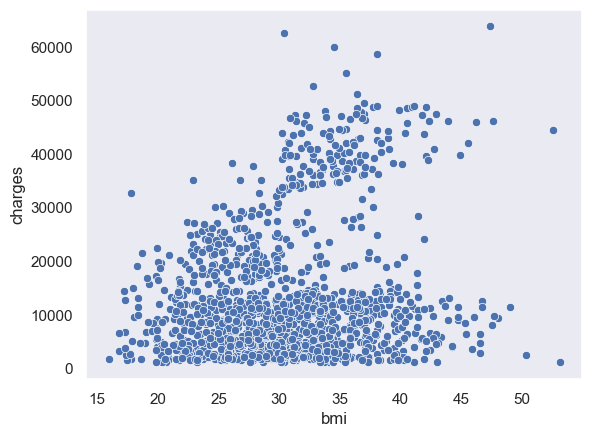

In [109]:
sns.scatterplot(data=insurance_df,x="bmi",y="charges") #to visualize relaiton between them

we can say that there is no linear relation between these two

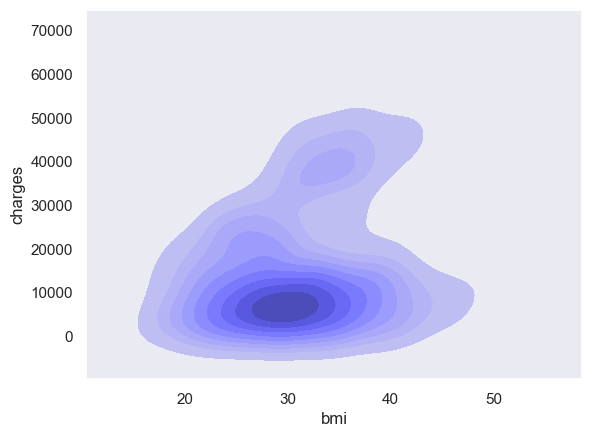

In [110]:
sns.kdeplot(data=insurance_df,x="bmi",y="charges",color="Blue",fill=True) #to visualize distributions within
sns.set(style="dark")

there is an unsual thing about this plot it looks like there is two clusters it means that the data is not uniformly distributed. which may happen due to skewness of the data.

### Examining the relationship between “region”, “smoker” and “bmi” using bar plot.

<Axes: xlabel='region', ylabel='charges'>

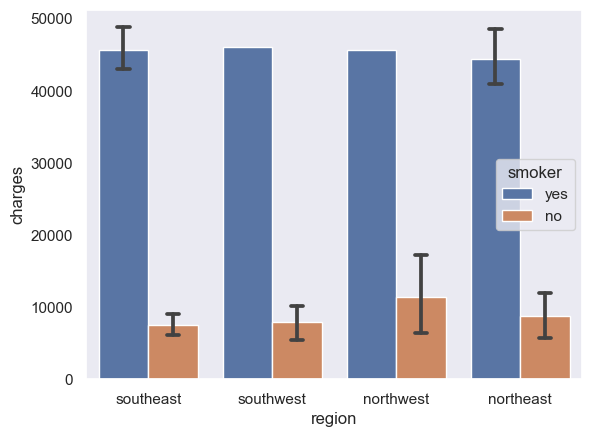

In [111]:
sns.barplot(
    x = 'region',
    y = 'charges',
    hue = 'smoker',
    data = insurance_df[insurance_df['bmi'] >= 40],
    capsize = 0.1
)

this plot indicates that people whose bmi's over 40 mostly smokes and gives the charge values depending on the region

### Skeweness of the target variable

<Axes: xlabel='charges', ylabel='Count'>

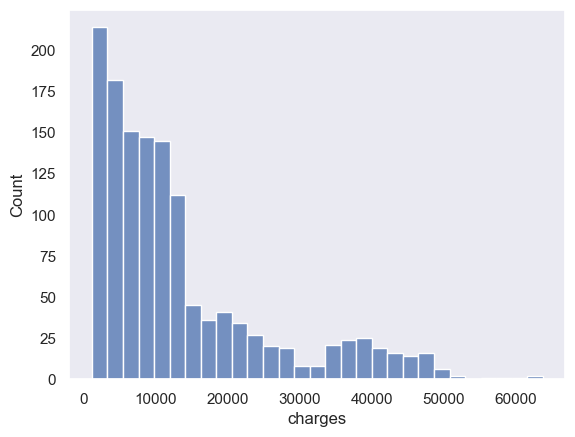

In [112]:
sns.histplot(data=insurance_df, x="charges")

since ctarget value is skewed,we need to rescale it using numpy.log1P

### Distribtion of the age values

<Axes: xlabel='age', ylabel='Density'>

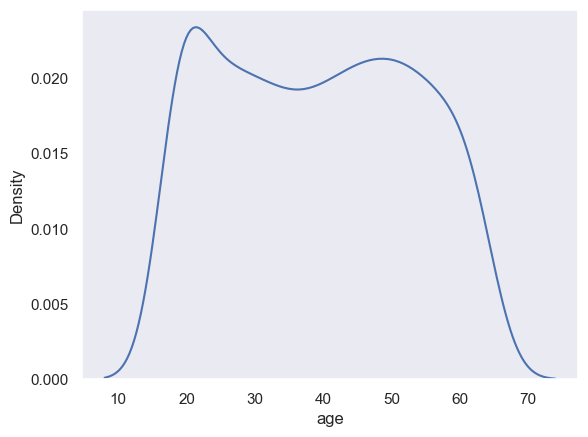

In [113]:
sns.kdeplot(data=insurance_df,x="age")

In the feature engineering part we can use this info to label diffrent ranges. i mean different label for age 10-35 and 35-70.

### Correlation HEatmap

<Axes: >

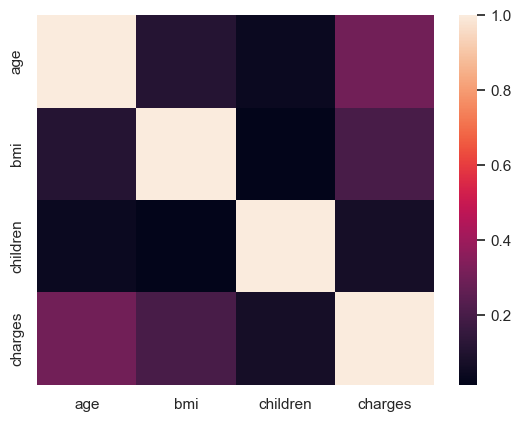

In [114]:
sns.heatmap(insurance_df.corr(numeric_only=True)) #just to visualize current correlations before adding more columns to the data

## Data Preprocessing

In [115]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Removing outliers

In [116]:
#shape before removing outlier rows on bmi
insurance_df.shape

(1337, 7)

In [117]:
insurance_df = insurance_df.loc[insurance_df['bmi'] <= Q3 + 1.5 *IQR] #masks the data below range

In [118]:
insurance_df.shape
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### Rescaling Target

<Axes: xlabel='charges', ylabel='Count'>

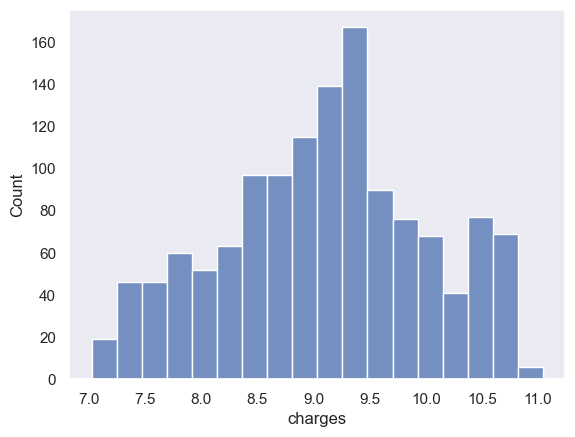

In [119]:
def scaler(col): #defining a scaler function
    col = np.log1p(col)
    return col

insurance_df["charges"] = scaler(insurance_df["charges"])

sns.histplot(data=insurance_df, x="charges")

### Feature Engineering

In [120]:
insurance_df['age_range'] = pd.cut(x=insurance_df['age'], bins=[0,35,70], labels=['Adult_1','Adult_2']) #i'vw seperated the age groups

In [121]:
insurance_df.describe()

,age,bmi,children,charges
count,1328.000000,1328.000000,1328.000000,1328.000000
mean,39.219127,30.537308,1.097139,9.098486
std,14.042170,5.922176,1.208008,0.915490
min,18.000000,15.960000,0.000000,7.023647
25%,27.000000,26.220000,0.000000,8.464915
50%,39.000000,30.300000,1.000000,9.145334
75%,51.000000,34.488750,2.000000,9.717476
max,64.000000,46.750000,5.000000,11.044423


In [122]:
insurance_df

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,9.734236,Adult_1
1,18,male,33.770,1,no,southeast,7.453882,Adult_1
2,28,male,33.000,3,no,southeast,8.400763,Adult_1
3,33,male,22.705,0,no,northwest,9.998137,Adult_1
4,32,male,28.880,0,no,northwest,8.260455,Adult_1
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,9.268755,Adult_2
1334,18,female,31.920,0,no,northeast,7.699381,Adult_1
1335,18,female,36.850,0,no,southeast,7.396847,Adult_1
1336,21,female,25.800,0,no,southwest,7.605365,Adult_1


### Encoding

In [123]:
insurance_df = pd.get_dummies(insurance_df)
insurance_df

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_range_Adult_1,age_range_Adult_2
0,19,27.900,0,9.734236,1,0,0,1,0,0,0,1,1,0
1,18,33.770,1,7.453882,0,1,1,0,0,0,1,0,1,0
2,28,33.000,3,8.400763,0,1,1,0,0,0,1,0,1,0
3,33,22.705,0,9.998137,0,1,1,0,0,1,0,0,1,0
4,32,28.880,0,8.260455,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,9.268755,0,1,1,0,0,1,0,0,0,1
1334,18,31.920,0,7.699381,1,0,1,0,1,0,0,0,1,0
1335,18,36.850,0,7.396847,1,0,1,0,0,0,1,0,1,0
1336,21,25.800,0,7.605365,1,0,1,0,0,0,0,1,1,0


<Axes: >

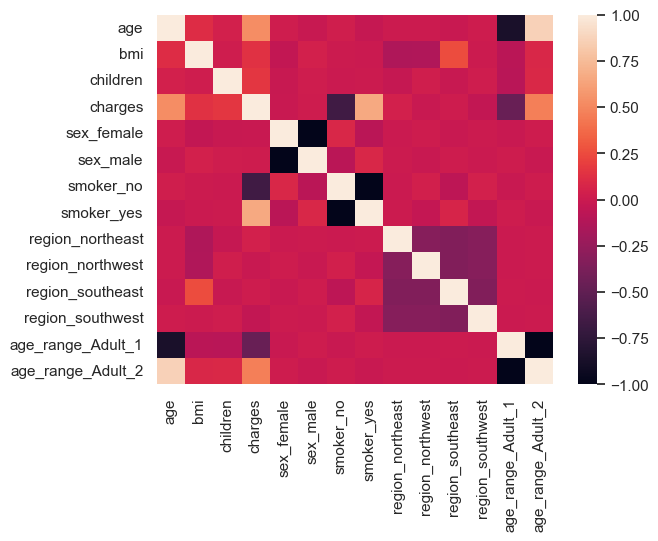

In [124]:
sns.heatmap(insurance_df.corr())

### Splitting data and Scaling

In [125]:
y = insurance_df.pop("charges")
X = insurance_df

In [126]:
display(X)
display(y)


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age_range_Adult_1,age_range_Adult_2
0,19,27.900,0,1,0,0,1,0,0,0,1,1,0
1,18,33.770,1,0,1,1,0,0,0,1,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0,1,0
4,32,28.880,0,0,1,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0,1,1,0,0,1,0,0,0,1
1334,18,31.920,0,1,0,1,0,1,0,0,0,1,0
1335,18,36.850,0,1,0,1,0,0,0,1,0,1,0
1336,21,25.800,0,1,0,1,0,0,0,0,1,1,0


0        9.734236
1        7.453882
2        8.400763
3        9.998137
4        8.260455
          ...    
1333     9.268755
1334     7.699381
1335     7.396847
1336     7.605365
1337    10.279948
Name: charges, Length: 1328, dtype: float64

In [127]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X) #scaling our data
display(X) 

array([[0.02173913, 0.38778824, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.57843456, 0.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.2173913 , 0.55342644, 0.6       , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.67846703, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06521739, 0.31958428, 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.93478261, 0.42578759, 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [128]:
x_train, x_test ,y_train, y_test = train_test_split(X,y,train_size=0.7)

## Model Selection

### Base Models

Text(11, 0.6918746783878211, 'local max')

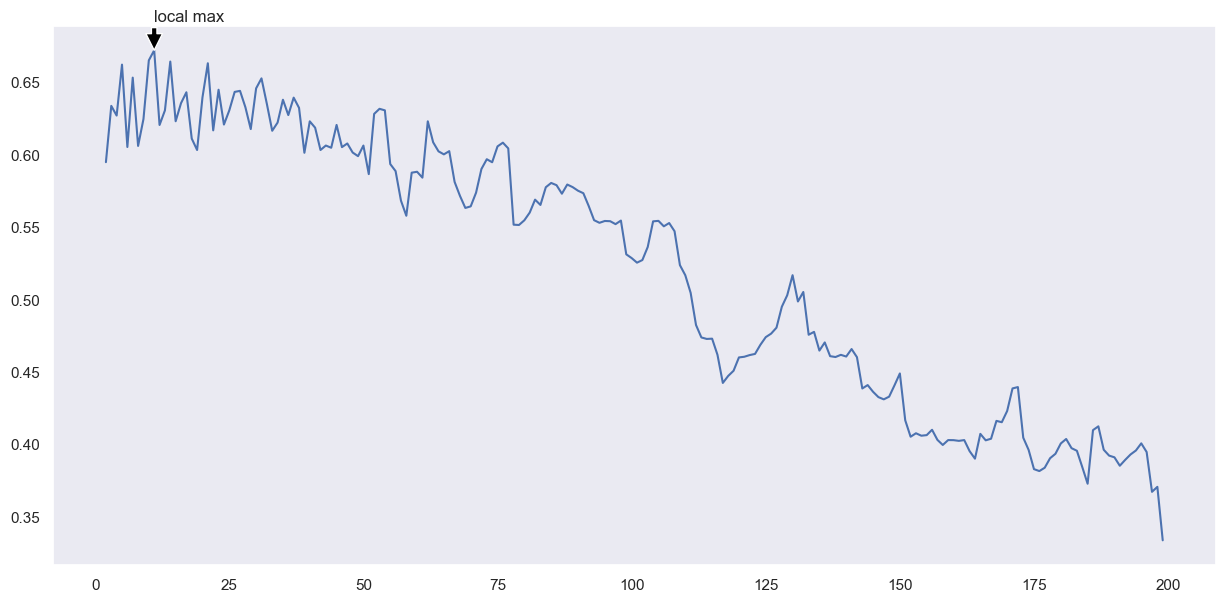

In [129]:
# RandomForestRegressor GradientBoostingRegressor lgb.LGBMRegressor These are the models i wan to try for this dataset

decision_tree = DecisionTreeRegressor(random_state=0)

decision_tree.fit(x_train,y_train)

from sklearn.model_selection import KFold
n_array =list()
scores = list()
for n in range(2,200): #this loop makes folds and calculates mean of the cross validation scores
    kf = KFold(n_splits=n)
    score = cross_val_score(estimator=decision_tree, X=x_train,y=y_train,cv=kf,n_jobs=-1)
    score.mean()
    scores.append(score.mean())
    n_array.append(n)
fig,ax = plt.subplots(1,1,figsize=(15,7))
plot_crosss =sns.lineplot(x=n_array,y=scores,ax=ax)
cross_series = pd.Series(data=scores,index=n_array)
ax.annotate('local max', xy=(cross_series.idxmax(), cross_series.max()), xytext=(cross_series.idxmax(), cross_series.max()+0.02), arrowprops=dict(facecolor='black'),)


In [130]:
display(mean_squared_error(y_true=y_test,y_pred=decision_tree.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=decision_tree.predict(x_test)))

0.27059837207787774

0.6816548527910335

In [131]:
lgbm = lgb.LGBMRegressor(random_state=0)

lgbm.fit(x_train,y_train)

display(mean_squared_error(y_true=y_test,y_pred=lgbm.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=lgbm.predict(x_test)))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 929, number of used features: 13
[LightGBM] [Info] Start training from score 9.077878


0.1383173203464225

0.8372767457205578

In [132]:
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(x_train,y_train)
display(mean_squared_error(y_true=y_test,y_pred=gbr.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=gbr.predict(x_test)))

0.11782607590480923

0.8613836469490059

In [139]:
rand_f = RandomForestRegressor(random_state=0)
rand_f.fit(x_train,y_train)
display(mean_squared_error(y_true=y_test,y_pred=rand_f.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=rand_f.predict(x_test)))

0.13162817978926394

0.8451461775246679

In [134]:
xgb_reg1 = XGBRegressor()
xgb_reg1.fit(x_train,y_train)
display(mean_squared_error(y_true=y_test,y_pred=xgb_reg1.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=xgb_reg1.predict(x_test)))

0.17009350044971466

0.7998936947618851

In [135]:
xgb_reg2 = XGBRFRegressor()
xgb_reg2.fit(x_train,y_train)
display(mean_squared_error(y_true=y_test,y_pred=xgb_reg2.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=xgb_reg2.predict(x_test)))

0.12149135669831851

0.8570716315262521

### Hyper-parameter Tuning & Model Evaluation

in this section i will tune xbrfregressor and Gradient Boostşing REgressor

In [148]:
##prameter grid for xgbrf

params_grid = {
    "n_estimators":[50,60,70,90,100,130],
    "max_depth":[5,10,15,20],
    "gamma":np.linspace(0.0001,4,3)
}

model_cv = GridSearchCV(xgb_reg2,param_grid=params_grid,refit=True,n_jobs=-1,cv=30,verbose=3)
model_cv.fit(x_train,y_train)

Fitting 30 folds for each of 90 candidates, totalling 2700 fits
[CV 1/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.920 total time=   0.0s
[CV 2/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.650 total time=   0.0s
[CV 3/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.811 total time=   0.0s
[CV 4/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.794 total time=   0.0s
[CV 5/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.785 total time=   0.0s
[CV 6/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.732 total time=   0.0s
[CV 7/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.768 total time=   0.0s
[CV 8/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.615 total time=   0.0s
[CV 10/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.761 total time=   0.0s
[CV 11/30] END gamma=0.0001, max_depth=4, n_estimators=50;, score=0.634 total time=   0.0s
[CV 12/30] END gamma=0.0001, max_d

GridSearchCV(cv=30,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      max_bin=None, max_cat_threshold=None,
                                      max...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      predictor=None, random_state=None,
                                      reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'gamma': array([1.00000e-04, 2.00005e+00, 4.00000e+00]),
                         'max_depth': [4, 5, 10, 15, 20],
                         'n_estimators': [50, 60, 70, 90, 100, 130]},
             verbose=3)

In [149]:
model_cv.best_estimator_

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0.0001, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=60, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, ...)

In [150]:
display(model_cv.best_params_)
display(model_cv.best_score_) #this gives total score based on X and y value as whole

#these give scores based on test partitions
display(mean_squared_error(y_true=y_test,y_pred=model_cv.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=model_cv.predict(x_test))) 

{'gamma': 0.0001, 'max_depth': 5, 'n_estimators': 60}

0.8044151999922917

0.11187467769978597

0.868385162601628

##### before tuning XGBRFRegressor we had mse and r2 respectively : 0.12149135669831851  | 0.8570716315262521
#####  after tuning the model we get lower mse and higher r2 0.11187467769978597    |   0.868385162601628 which improves prediction of the test data.

In [194]:
##prameter grid for gradient boosting machine regressor

params_grid = {
    "n_estimators":[55,60,65,70,80,100],
    "max_depth":[3,5,10,15,20],
    "gamma":np.linspace(0.0001,3,1),
    "learning_rate":[1.001, 1.01, 1.0001]
}

model_gbr = GridSearchCV(xgb_reg2,param_grid=params_grid,refit=True,n_jobs=-1,cv=30,verbose=3)
model_gbr.fit(x_train,y_train)


Fitting 30 folds for each of 90 candidates, totalling 2700 fits
[CV 1/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.902 total time=   0.0s
[CV 2/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.550 total time=   0.0s
[CV 3/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.796 total time=   0.0s
[CV 4/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.781 total time=   0.0s
[CV 5/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.770 total time=   0.0s
[CV 7/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.786 total time=   0.0s
[CV 6/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.712 total time=   0.0s
[CV 8/30] END gamma=0.0001, learning_rate=1.001, max_depth=3, n_estimators=55;, score=0.617 total time=   0.0s
[CV 9/30] END gamma=0.0001, learning_rate=1.001,

GridSearchCV(cv=30,
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      max_bin=None, max_cat_threshold=None,
                                      max...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      predictor=None, random_state=None,
                                      reg_alpha=None, ...),
             n_jobs=-1,
             param_grid={'gamma': array([0.0001]),
                         'learning_rate': [1.001, 1.01, 1.0001],
                         'max_depth': [3, 5, 10, 15, 20],
                         'n_estimators': [55, 60, 65, 70, 80, 100]},
             verbose=3)

In [196]:
display(model_gbr.best_params_)
display(model_gbr.best_score_) #this gives total score based on x_train and y_train

#these give scores based on test partitions
display(mean_squared_error(y_true=y_test,y_pred=model_gbr.predict(x_test)))
display(r2_score(y_true=y_test,y_pred=model_gbr.predict(x_test))) 

{'gamma': 0.0001, 'learning_rate': 1.0001, 'max_depth': 5, 'n_estimators': 60}

0.8044172670158124

0.1119170394932371

0.8683353261178802

##### before tuning GBR we had mse and r2 respectively : 11782607590480923 | 0.8613836469490059
#####  after tuning the model we get lower mse and higher r2 0.1119170394932371 | 0.8683353261178802 but it is not improved noticebly

## Conclusions


In this notebook, I explored the dataset with a set of visualizations and then implemented various ML algorithms to predict the test data the best.
Since it is more robust to the test data, it is best to choose tuned-XGBRFRegressor.
If the dataset was big enough to further adjust the model, I could implement different groups for the charge column. This means that if a patient's medical cost is significantly higher than the other charge range (approximately 34,000-50,000), then we can say that it is because they are rich or they tend to have more expenses.